# Read in stacks with a header and applied template

## Setup

### Create an environment with the following command
```
conda create -c conda-forge -n h5py_napari numpy h5py matplotlib napari jupyter notebook
```

### Activate the environment and launch jupyter
```
conda activate h5py_napari
jupyter notebook
```

# Apply Template using Julia

A binary template needs to be applied to the stack files using Julia first. The stacks must have been generated with a 2048 byte header before each timepoint. Applying the template using Julia will turn the stacks with headers into a valid HDF5 file. `h5py` currently does not have the full capability to generate the template.

The Julia package can currently be found at https://github.com/JaneliaSciComp/MatrixMicroscopeUtils.jl

```julia
using MatrixMicroscopeUtils
cd(raw"D:\target\directory\with\stack\files")
MatrixMicroscopeUtils.batch_apply_uint24_template()
```

## Keywords

If a template was previously applied, you may need to force the application in the case of errors. The default options are meant to help protect you from accidentally overwriting data. You may need to pause to consider if there may be another issue such as being in the wrong directory. Misapplication of the following command can result in the loss of data!
* `ensure_zeros` - Setting this to `true` (default) makes sure that all bytes being overwritten are zero, which should be the case for a fresh stack. Setting this to `false` will let you overwrite a previous template application.
* `truncate` - Setting this to `false` (default) will make sure the file is not longer than the template. Setting this to `true` will allow the function to remove bytes at the end of the file, which may exist if a template was previously applied.
```julia
MatrixMicroscopeUtils.batch_apply_uint24_template(ensure_zero = false, truncate = true)
```

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import re
import os
import napari
from skimage import data

The files at `\\Keller-S10\Data\Matrix\22-03-10\_20220310_110256(header 2048)\h5_template_applied` already have the template applied.

In [2]:
demo_folder = r"\\Keller-S10\Data\Matrix\22-03-10\_20220310_110256(header 2048)\h5_template_applied"
os.chdir(demo_folder)

Uncomment the folowing if you have pyjulia working and want to apply the template.

See https://pyjulia.readthedocs.io/en/latest/usage.html#ipython-magic

In [3]:
# %load_ext julia.magic
# %julia using MatrixMicroscopeUtils
# %julia MatrixMicroscopeUtils.batch_apply_uint24_template()

In [4]:
def read_timepoint(filename = "TM0000000_CM2.stack", timepoint = 0):
    """
        read_timepoint(filename, timepoint)
        
    filename: name of the file as a string
    timepoint: integer presenting the timepoint to load
    """
    m = re.search("(TM\d{7})_CM(\d).stack", filename)
    camera = int(m.group(2))
    with h5py.File(filename) as h5f:
        # Read in 24-bit pixels as 32-bit integers
        A = h5f[f"CM%d/TM%07d" % (camera, timepoint)].astype("uint32")[:]
        # Extract 12-bit pixels as 16-bit integers
        tp_data = np.empty((A.shape[0], A.shape[1], A.shape[2]*2), dtype="uint16")
        tp_data[:,:,0::2] = A & 0xfff
        tp_data[:,:,1::2] = A >> 12
    
    return tp_data

def write_timepoint_to_raw_stack(tp_data, timepoint = 0, camera = 1):
    """
        write_timepoint_to_raw_stack(tp_data, timepoint, camera)
        
    tp_data: data returned from `read_timepoint`
    timepoint: integer representing the timepoint to save
    camera: integer representing the camera number
    
    The stack will be written to a file with a name like "TM0000000_CM2_uint16.stack".
    This stack will not be a valid HDF5 file or have header spacings between timepoints.
    You should probably place these in another folder to avoid confusion.
    """
    with open(f"TM%07d_CM%d_uint16.stack" % (timepoint, camera), "bw") as f:
        f.write(tp_data)
        
    return None

In [5]:
# Read in a timepoint after modification with the Julia script

%time TM0000000 = read_timepoint("TM0000000_CM2.stack", 0)
%time TM0000001 = read_timepoint("TM0000000_CM2.stack", 1)
%time TM0000002 = read_timepoint("TM0000000_CM2.stack", 2)

Wall time: 672 ms
Wall time: 637 ms
Wall time: 679 ms


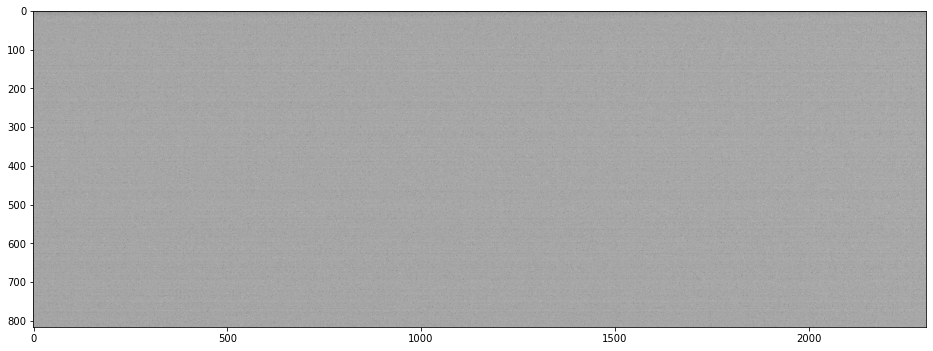

In [6]:
# Show the 6th plane of TM0000000

plt.figure(figsize=(16, 12))
plt.imshow(TM0000000[5,:,:], cmap='Greys')

# Napari


In [7]:
# View the timepoints with Napari, each 3d timepoint in a separate layer

viewer = napari.view_image(TM0000000)
viewer.add_image(TM0000001)
viewer.add_image(TM0000002)
napari.run()

In [8]:
# Stack those timepoints into a 4D time series and view

timeseries = np.stack([TM0000000, TM0000001, TM0000002])
viewer = napari.view_image(timeseries)
napari.run()

# Loading full stacks

Load an entire 2 GB stack at once and view in Napari. Combine multiple 2 GB stacks into a single time series.

This part can be slow. I may consider rewriting this using dask to avoid the initial latency. The `read_timepoints` function below allows you to read in multiple timepoints at once without opening and closing the file multiple times.

In [9]:
# Read in multiple timepoints at once

def read_timepoints(filename = "TM0000000_CM2.stack", timepoints = range(0,44)):
    m = re.search("(TM\d{7})_CM(\d).stack", filename)
    camera = int(m.group(2))
    num_timepoints = len(timepoints)
    tp_stack = []
    with h5py.File(filename) as h5f:
        for timepoint in timepoints:
            # Read in 24-bit pixels as 32-bit integers
            A = h5f[f"CM%d/TM%07d" % (camera, timepoint)].astype("uint32")[:]
            tp_data = np.empty((A.shape[0], A.shape[1], A.shape[2]*2), dtype="uint16")
            # Extract 12-bit pixels as 16-bit integers
            tp_data[:,:,0::2] = A & 0xfff
            tp_data[:,:,1::2] = A >> 12
            tp_stack.append(tp_data)
    return np.stack(tp_stack)


In [10]:
# Read in timepoints in TM0000000_CM2.stack
# This could take 60 seconds or more

%time TM0000000_stack = read_timepoints("TM0000000_CM2.stack", range(0,44))

Wall time: 30.9 s


In [11]:
# View timepoints in TM0000000_CM2.stack

viewer = napari.view_image(TM0000000_stack)
napari.run()

In [12]:
# Read in timepoints in TM0000044_CM2.stack
# This could take 60 seconds or more

%time TM0000044_stack = read_timepoints("TM0000044_CM2.stack", range(44,88))

Wall time: 33.2 s


In [13]:
# Read in timepoints in TM0000000_CM2.stack and TM0000044_CM2.stack in a single stack

combined_stack = np.concatenate([TM0000000_stack, TM0000044_stack])
viewer = napari.view_image(combined_stack)
napari.run()

# Synthetic Example

I modified an existing stack

In [14]:
os.chdir(r"\\Keller-S10\Data\Matrix\RC_21-09-27\USAF_101us-exp_17Hz_20210927_142956\synthetic_header")
%time synthetic_stack = read_timepoints("TM0000000_CM1.stack", range(0,14))
viewer = napari.view_image(synthetic_stack)
napari.run()
os.chdir(demo_folder)

Wall time: 31 s
